# Modelo por defecto para SAP2000


**1. dependencias**

In [26]:
import os, sys
import comtypes.client

**2. Establecimiento de coneccion por defecto o manual**

In [27]:
#establezca el siguiente indicador en True para adjuntarlo a una instancia existente del programa SAP2000
# True o 1: Para indicar si va a trabajar con el programa abierto de SAP2000
AttachToInstance = False

# establezca el siguiente indicador en True para especificar manualmente la ruta a SAP2000.exe
# esto permite una conexión a una versión de SAP2000 que no sea la última instalación
# de lo contrario, se lanzará la última versión instalada de SAP2000
SpecifyPath = False

ProgramPath = "C:\\Program Files\\Computers and Structures\\SAP2000 23\\SAP2000.exe"

# helper = comtypes.client.CreateObject('SAP2000v1.helper')
# helper = helper.QueryInterface(comtypes.gen.SAP2000v19.cHelper)
helper = comtypes\
    .client.CreateObject('SAP2000v1.Helper')\
    .QueryInterface(comtypes.gen.SAP2000v1.cHelper)

if AttachToInstance:
    try:
        SAP2000Object = helper.GetObject("CSI.SAP2000.API.SapObject")
        print("Coneccion exitosa!.\nadjuntando a una instancia existente.")
    except (OSError, comtypes.COMError):
        print("No se encontró ninguna instancia en ejecución del programa.")
        sys.exit(-1)
else:
    if SpecifyPath: # para versiones anteriores a la ultima version
        try:
            SAP2000Object = helper.CreateObject(ProgramPath)
            print("Coneccion esitosa!.\nConexion Manual")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program from " + ProgramPath)
            sys.exit(-1)
    else:
        try: 
            SAP2000Object = helper.CreateObjectProgID("CSI.SAP2000.API.SapObject")
            print("Coneccion esitosa!. ultima version instalada")
        except (OSError, comtypes.COMError):
            print("Cannot start a new instance of the program.")
            sys.exit(-1)

    #start SAP2000 application
    SAP2000Object.ApplicationStart()

Ejecucion a la ultima version del programa


**3. Se crea el objeto SapModel o instancia a la Clase (se crea un objeto o instancia)**

In [28]:
#create SapModel object | crea instancia del objeto SapModel
smodel = SAP2000Object.SapModel # es equivalente a smodel = SAP2000Object.SapModel()
smodel

<POINTER(cSapModel) ptr=0x1df26faf8a0 at 1df487c7b50>

**4. Inicia o crear un lienzo en blanco**

In [29]:
# 'initialize model | Inicializa una hoja en blanco para definir un modelo
# resUnit = smodel.InitializeNewModel # este tambien es aceptado, pero es un metodo sin parametros
smodel.InitializeNewModel() # en cambio aqui se puede enviar parametros

0

**5. Ahora se crea un nuevo modelo**

In [30]:
#create new blank model
res = smodel.File.NewBlank()
display(res)

0

**7. Se establece propiedades mecanicas del material para la estructura**

Propiedades mecanicas del concreto

In [31]:
#define material property | Define propiedes de material
MATERIAL_CONCRETE = 2
res = smodel.PropMaterial.SetMaterial('CONC', MATERIAL_CONCRETE)
display(res)

0

In [32]:
#assign isotropic mechanical properties to material | Asigna Propiedades isotropicas al material en MPa
res = smodel.PropMaterial.SetMPIsotropic(
    'CONC', # nombre
    3600, # E: modulo young o elasticidad
    0.2, # v: modulo de posson
    0.0000055 # T: Coeficiente termico
    )
display(res)

0

**8. Se establece propiedades de material para el Frame**

In [33]:
#define rectangular frame section property | Define seccion de tipo rectangular al elemento (frame)
res = smodel.PropFrame.SetRectangle('R1', 'CONC', 12, 12)
display(res)

0

In [34]:
#define frame section property modifiers | Define Modificadores de propiedades al frame
ModValue = [1000, 0, 0, 1, 1, 1, 1, 1]
res = smodel.PropFrame.SetModifiers('R1', ModValue)
display(res)

[(1000.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0), 0]

**9. Se establece Unidades para el modelo**

In [35]:
# #switch to k-ft units
kip_ft_F = 4
res = smodel.SetPresentUnits(kip_ft_F)
display(res)

0

**10. Se establece la geometria (vertices o coordenadas) y elementos**

In [36]:
#add frame object by coordinates
FrameName1 = ' '
FrameName2 = ' '
FrameName3 = ' '
[FrameName1, res] = smodel.FrameObj.AddByCoord(0, 0, 0, 0, 0, 10, FrameName1, 'R1', '1', 'Global')
[FrameName2, res] = smodel.FrameObj.AddByCoord(0, 0, 10, 8, 0, 16, FrameName2, 'R1', '2', 'Global')
[FrameName3, res] = smodel.FrameObj.AddByCoord(-4, 0, 10, 0, 0, 10, FrameName3, 'R1', '3', 'Global')
display([FrameName3, res])

['3', 0]

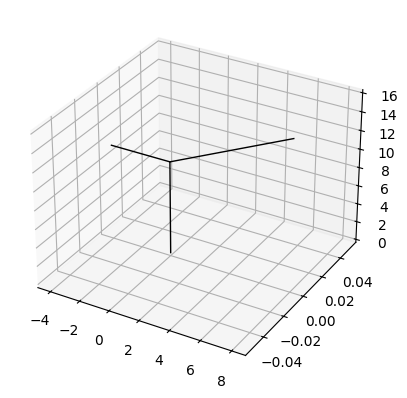

In [37]:
import numpy as np
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

coords = np.array([[0,0,0],[0,0,10],[8,0,16],[-4,0,10]]);
i, j = None, None
plt.figure(1)
plt.axes(projection='3d')
for e in range (1,4):
    elems = smodel.FrameObj.GetPoints(str(e), i, j);
    deNodo = int(elems[0])
    alNodo = int(elems[1])
    cxyz = np.array([\
        [coords[deNodo-1,0], coords[deNodo-1,1], coords[deNodo-1,2]], 
        [coords[alNodo-1,0], coords[alNodo-1,1], coords[alNodo-1,2]]
    ]);
    plt.plot(cxyz[:,0],cxyz[:,1], cxyz[:,2], 'k-', lw=1);

plt.grid()

**11. Se asigna las restricciones o condiciones de borde o apoyos**

In [38]:
#assign point object restraint at base
PointName1 = ' '
PointName2 = ' '
#           [Fx,   Fy,   Fz,   Rx,   Ry,    Rz]
Restraint = [True, True, True, True, False, False]
[PointName1, PointName2, res] = smodel.FrameObj.GetPoints(FrameName1, PointName1, PointName2)
display([PointName1, PointName2, res])

res = smodel.PointObj.SetRestraint(PointName1, Restraint)
display(res)

['1', '2', 0]

[(True, True, True, True, False, False), 0]

In [39]:
#assign point object restraint at top
#           [Fx,   Fy,   Fz,   Rx,   Ry,    Rz]
Restraint = [True, True, False, False, False, False]
[PointName1, PointName2, res] = smodel.FrameObj.GetPoints(FrameName2, PointName1, PointName2)
res = smodel.PointObj.SetRestraint(PointName2, Restraint)
display(res)

[(True, True, False, False, False, False), 0]

**12. Se refresca el modelo**

In [40]:
#refresh view, update (initialize) zoom
res = smodel.View.RefreshView(0, False)
display(res)

0

**13. Se establece las cargas puntuales y distribuidas a la estructura**

In [41]:
#add load patterns
LTYPE_OTHER = 8
res = smodel.LoadPatterns.Add('1', LTYPE_OTHER, 1, True)
res = smodel.LoadPatterns.Add('2', LTYPE_OTHER, 0, True)
res = smodel.LoadPatterns.Add('3', LTYPE_OTHER, 0, True)
res = smodel.LoadPatterns.Add('4', LTYPE_OTHER, 0, True)
res = smodel.LoadPatterns.Add('5', LTYPE_OTHER, 0, True)
res = smodel.LoadPatterns.Add('6', LTYPE_OTHER, 0, True)
res = smodel.LoadPatterns.Add('7', LTYPE_OTHER, 0, True)
display(res)

#assign loading for load pattern 2
[PointName1, PointName2, res] = smodel.FrameObj.GetPoints(FrameName3, PointName1, PointName2)
PointLoadValue = [0,0,-10,0,0,0]
res = smodel.PointObj.SetLoadForce(PointName1, '2', PointLoadValue)
res = smodel.FrameObj.SetLoadDistributed(FrameName3, '2', 1, 10, 0, 1, 1.8, 1.8)
display(res)

#assign loading for load pattern 3
[PointName1, PointName2, res] = smodel.FrameObj.GetPoints(FrameName3, PointName1, PointName2)
PointLoadValue = [0,0,-17.2,0,-54.4,0]
res = smodel.PointObj.SetLoadForce(PointName2, '3', PointLoadValue)
display(res)

#assign loading for load pattern 4
res = smodel.FrameObj.SetLoadDistributed(FrameName2, '4', 1, 11, 0, 1, 2, 2)
display(res)

#assign loading for load pattern 5
res = smodel.FrameObj.SetLoadDistributed(FrameName1, '5', 1, 2, 0, 1, 2, 2, 'Local')
res = smodel.FrameObj.SetLoadDistributed(FrameName2, '5', 1, 2, 0, 1, -2, -2, 'Local')
display(res)

#assign loading for load pattern 6
res = smodel.FrameObj.SetLoadDistributed(FrameName1, '6', 1, 2, 0, 1, 0.9984, 0.3744, 'Local')
res = smodel.FrameObj.SetLoadDistributed(FrameName2, '6', 1, 2, 0, 1, -0.3744, 0, 'Local')
display(res)

#assign loading for load pattern 7
res = smodel.FrameObj.SetLoadPoint(FrameName2, '7', 1, 2, 0.5, -15, 'Local')
display(res)


0

0

[(0.0, 0.0, -17.2, 0.0, -54.4, 0.0), 0]

0

0

0

0

**14. establecemos las unidades de las cargas**

In [42]:
#switch to k-in units
kip_in_F = 3
smodel.SetPresentUnits(kip_in_F)

0

**15. Guardamos el modelo**

In [43]:
APIPath = 'C:\\CSi_API_Example'
if not os.path.exists(APIPath):
    try:
        os.makedirs(APIPath)
    except OSError:
        pass
ModelPath = APIPath + os.sep + 'API_1-001.sdb'


In [44]:
#save model
smodel.File.Save(ModelPath)

0

**16. Ejecutar analisis**

In [45]:
#run model (this will create the analysis model)
smodel.Analyze.RunAnalysis()

0

**Acceso a metodo `SetModelIsLocked(arg)`, el argumento debe ser un boleano**

In [46]:
# Unlocking model | Abriendo modelo para establecer nueva ejecucion (hace referencia al candadito)
# smodel.SetModelIsLocked(False)
# get value | Optner el valor.
print(smodel.GetModelIsLocked()) # False

True


Cerramos la Coneccion o la aplicacion

In [51]:
if (SAP2000Object.ApplicationExit(False)):
    print("SAP2000, No se pudo cerrar")
else:
    print("Se cerro con exito.")

smodel = None
SAP2000Object = None
del smodel, SAP2000Object, res
exit(-1)

Se cerro con exito.


**17. desplazamientos**

In [50]:
#initialize for results | 
ProgramResult = [0,0,0,0,0,0,0]
[PointName1, PointName2, res] = smodel.FrameObj.GetPoints(FrameName2, PointName1, PointName2)

#get results for load cases 1 through 7 | Optenemos los resultados para los casos de carga de 1 al 7
for i in range(0,7):
    NumberResults = 0
    Obj = []
    Elm = []
    ACase = []
    StepType = []
    StepNum = []
    U1 = []
    U2 = []
    U3 = []
    R1 = []
    R2 = []
    R3 = []
    ObjectElm = 0
    res = smodel.Results.Setup.DeselectAllCasesAndCombosForOutput()
    res = smodel.Results.Setup.SetCaseSelectedForOutput(str(i + 1))
    if i <= 3:
        [NumberResults, Obj, Elm, ACase, StepType, StepNum, U1, U2, U3, R1, R2, R3, res] = smodel.Results.JointDispl(PointName2, ObjectElm, NumberResults, Obj, Elm, ACase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
        ProgramResult[i] = U3[0]
    else:
        [NumberResults, Obj, Elm, ACase, StepType, StepNum, U1, U2, U3, R1, R2, R3, res] = smodel.Results.JointDispl(PointName1, ObjectElm, NumberResults, Obj, Elm, ACase, StepType, StepNum, U1, U2, U3, R1, R2, R3)
        ProgramResult[i] = U1[0]

[-0.02641139257979737, -0.02639, 0.0008106320499192687]
[0.06295961111187433, 0.06296, -6.176749137165594e-06]
[0.06295961111187433, 0.06296, -6.176749137165594e-06]
[-0.2963018518554431, -0.2963, 6.2499339963384415e-06]
[0.31250185185563956, 0.3125, 5.925938046491552e-06]
[0.11555582518658579, 0.11556, -3.6126803515168504e-05]
[0.006511371527856692, 0.00651, 0.00021068016231828857]


Test o prueba de resultados

In [ ]:
#fill independent results | Estos datos son para comparar o lo mismo que test
IndResult = [0,0,0,0,0,0,0]
IndResult[0] = -0.02639
IndResult[1] = 0.06296
IndResult[2] = 0.06296
IndResult[3] = -0.2963
IndResult[4] = 0.3125
IndResult[5] = 0.11556
IndResult[6] = 0.00651

#fill percent difference | Porcentaje de error en calculo
PercentDiff = [0,0,0,0,0,0,0]
for i in range(0,7):
    PercentDiff[i] = (ProgramResult[i] / IndResult[i]) - 1
    #display results | se muestra los resultados optenidos
    print([ ProgramResult[i], IndResult[i], PercentDiff[i] ])

In [ ]:
correct_displacement = np.array(IndResult).round(4); # Datos de calculo manual
calculated_disp = np.array(ProgramResult).round(4); # calculo generado
assert np.allclose(calculated_disp, correct_displacement), " Your scritp is probably wrong"
print("All correct. Good work !.")